<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EB%B9%84%EC%A7%80%EB%8F%84_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Customers clustering: K-Means, DBSCAN and AP**
https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

KMeans, Affinity Propagation and DBSCAN 사용

#1. Introduction
클러스터링 목적 : label 없는 데이터셋에서 natural 그룹 찾기. => 비지도 학습. 고객 분류, 이미지 분류 등에서 자주 사용된다. 

두 가지 군집화 알고리즘
- Hierarchical : 데이터셋을 계속 쪼갬. 클러스터의 개수를 지정할 필요능 없지만 termination condition을 지정해야함.
- Partitional : 데이터셋을 주어진 기준에 따라 여러 하위 집단으로 나눔. 클러스터 개수를 미리 지정하는 것은 어렵기 때문에 다른 간단한 접근법이 나와 있다.

제일 나은 알고리즘 같은 건 없음. 데이터에 따라 최적의 방법을 골라야한다.

#2. Reading Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('seaborn version: {}'.format(sns.__version__))

pandas version: 1.4.4
numpy version: 1.22.4
seaborn version: 0.12.2


In [2]:
mall_data=pd.read_csv('Mall_Customers.csv')
print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [3]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
139,140,Female,35,74,72
39,40,Female,20,37,75
76,77,Female,45,54,53
35,36,Female,21,33,81
30,31,Male,60,30,4
189,190,Female,36,103,85
27,28,Male,35,28,61
101,102,Female,49,62,48
160,161,Female,56,79,35
142,143,Female,28,76,40


In [4]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


범주형인 성별 칼럼을 원-핫 인코딩 하고 싶지만 안하는게 낫다. binary형 데이터는 그 특징 때문에 kmeans 방법이 제대로 작동하지 않기 때문.

In [5]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

결측치도 없다.

#3. Explanatory Data Analysis
통계적 탐색을 해보자.

##3.1 Distributions
숫자형 변수들의 분포를 살펴보자. 유일한 범주형 변수인 성별로 나눠보자.

<ipython-input-6-8e5f50eebfc1>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
<ipython-input-6-8e5f50eebfc1>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_age, bins=age_bins, kd

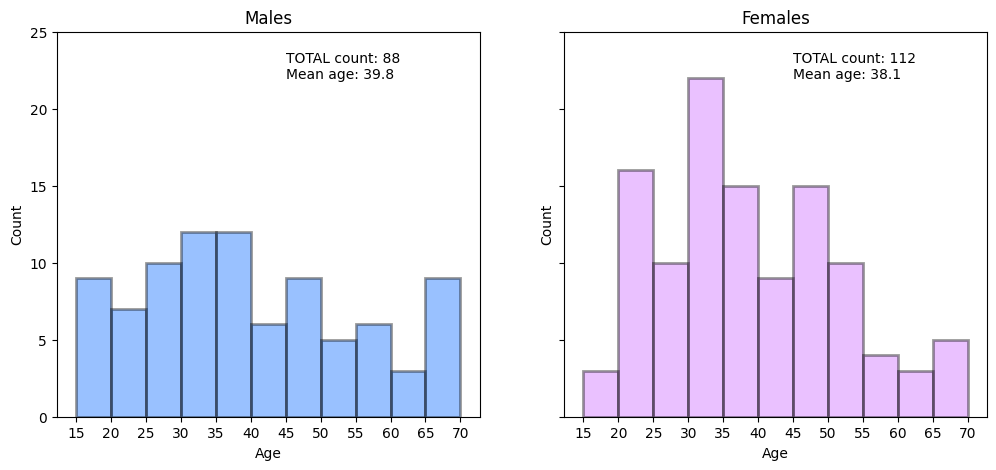

In [6]:
males_age=mall_data[mall_data['Gender']=='Male']['Age'] #subset with males age
females_age=mall_data[mall_data['Gender']=='Female']['Age'] #subset with females age

age_bins=range(15, 75, 5)

#males histogram
fig2, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45, 23, 'TOTAL count: {}'.format(males_age.count()))
ax1.text(45, 22, 'Mean age: {:.1f}'.format(males_age.mean()))

#females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor='k', linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45, 23, 'TOTAL count: {}'.format(females_age.count()))
ax2.text(45, 22, 'Mean age: {:.1f}'.format(females_age.mean()))

plt.show()

In [7]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


남자 고객의 평균 나이가 약간 더 높다. 그리고 더 정규성이 있다. Kolgomorob 테스트로 두 그룹이 통계적으로 차이가 있는지 검정했다.

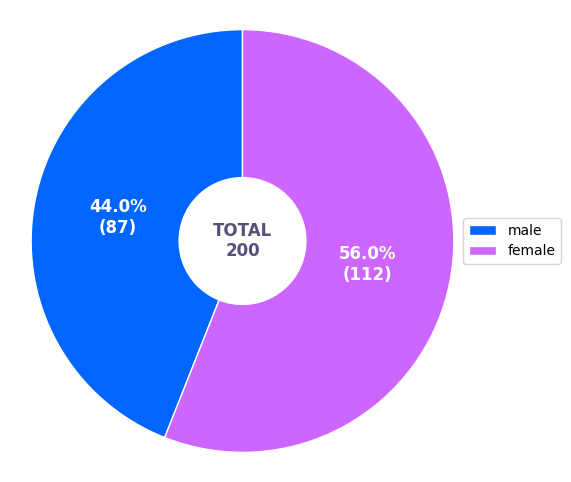

In [8]:
def labeler(pct, allvals):
  absolute=int(pct/100.*np.sum(allvals))
  return '{:.1f}%\n({:d})'.format(pct, absolute)

sizes=[males_age.count(),females_age.count()] #wedge sizes

fig0, ax1=plt.subplots(figsize=(6, 6))
wedges, texts, autotexts=ax1.pie(sizes,
                                 autopct=lambda pct: labeler(pct, sizes),
                                 radius=1,
                                 colors=['#0066ff', '#cc66ff'],
                                 startangle=90,
                                 textprops=dict(color='w'),
                                 wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male', 'female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0, 0, 'TOTAL\n{}'.format(mall_data['Age'].count()), weight='bold', size=12, color='#52527a', ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  #equal aspect ratio
plt.show()

여성 고객 수가 조금 더 많다. 총 고객의 56% 정도.

<ipython-input-9-a133ec6effe0>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
<ipython-input-9-a133ec6effe0>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_income, bins=my_bins

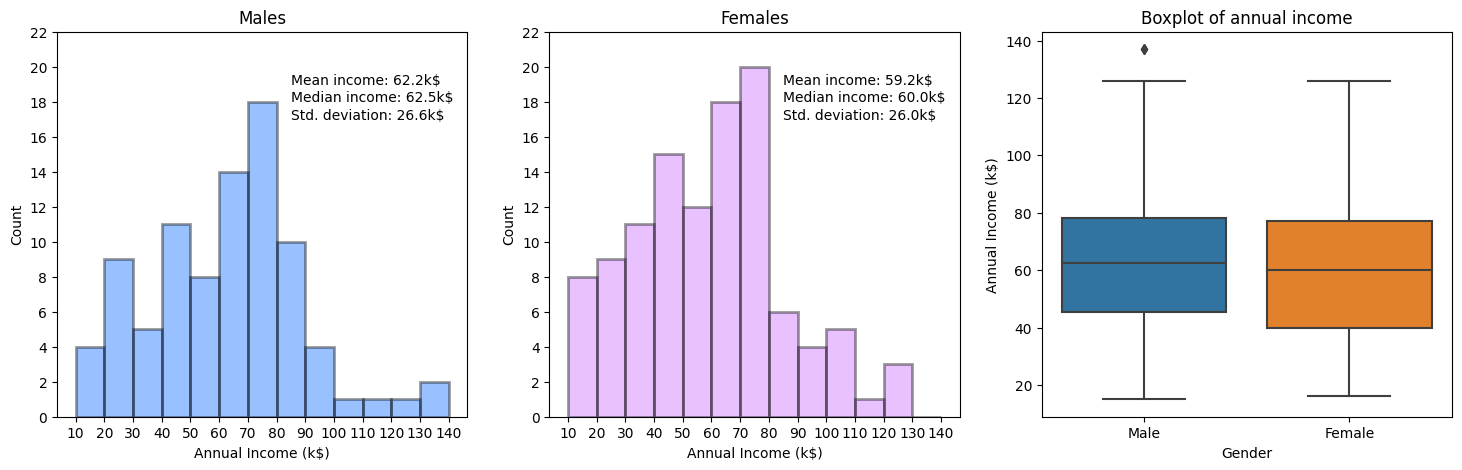

In [9]:
males_income=mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] #subset with males income
females_income=mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] #subset with females income

my_bins=range(10, 150, 10)

#males histogram
fig, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(18, 5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0, 24, 2))
ax1.set_ylim(0, 22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85, 19, 'Mean income: {:.1f}k$'.format(males_income.mean()))
ax1.text(85, 18, 'Median income: {:.1f}k$'.format(males_income.median()))
ax1.text(85, 17, 'Std. deviation: {:.1f}k$'.format(males_income.std()))

#females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor='k', linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0, 24, 2))
ax2.set_ylim(0, 22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85, 19, 'Mean income: {:.1f}k$'.format(females_income.mean()))
ax2.text(85, 18, 'Median income: {:.1f}k$'.format(females_income.median()))
ax2.text(85, 17, 'Std. deviation: {:.1f}k$'.format(females_income.std()))

#boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [10]:

print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


남자 고객의 평균 수입이 더 높다. 중간값도 더 높다. 분산은 비슷하다. 남자 그룹에 이상치가 하나 있다. 하지만 검정 결과 두 그룹이 통계적으로 차이는 없다.

<ipython-input-11-e385db2fd3d8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
<ipython-input-11-e385db2fd3d8>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_spending, 

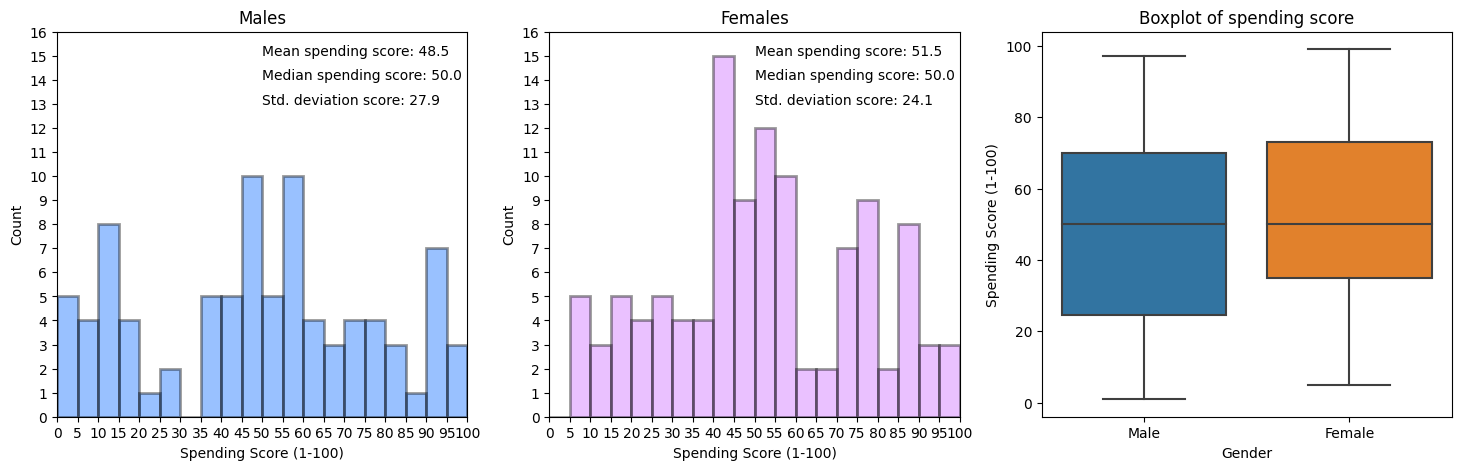

In [11]:
males_spending=mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] #subset with males age
females_spending=mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] #subset with females age

spending_bins=range(0, 105, 5)

#males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0, 100)
ax1.set_yticks(range(0, 17, 1))
ax1.set_ylim(0, 16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50, 15, 'Mean spending score: {:.1f}'.format(males_spending.mean()))
ax1.text(50, 14, 'Median spending score: {:.1f}'.format(males_spending.median()))
ax1.text(50, 13, 'Std. deviation score: {:.1f}'.format(males_spending.std()))

#females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor='k', linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0, 100)
ax2.set_yticks(range(0, 17, 1))
ax2.set_ylim(0, 16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50, 15, 'Mean spending score: {:.1f}'.format(females_spending.mean()))
ax2.text(50, 14, 'Median spending score: {:.1f}'.format(females_spending.median()))
ax2.text(50, 13, 'Std. deviation score: {:.1f}'.format(females_spending.std()))

#boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [12]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


여성 고객의 평균 소비 점수가 더 높다. 검정 결과 두 그룹에 차이는 없지만 이전 결과들에 비해 p-value가 낮아서 이전 비교들만큼 강력한 증거는 못 된다.

연령 그룹별로 수입 중간값을 계산해보자.

In [13]:
medians_by_age_group=mall_data.groupby(['Gender', pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index=medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

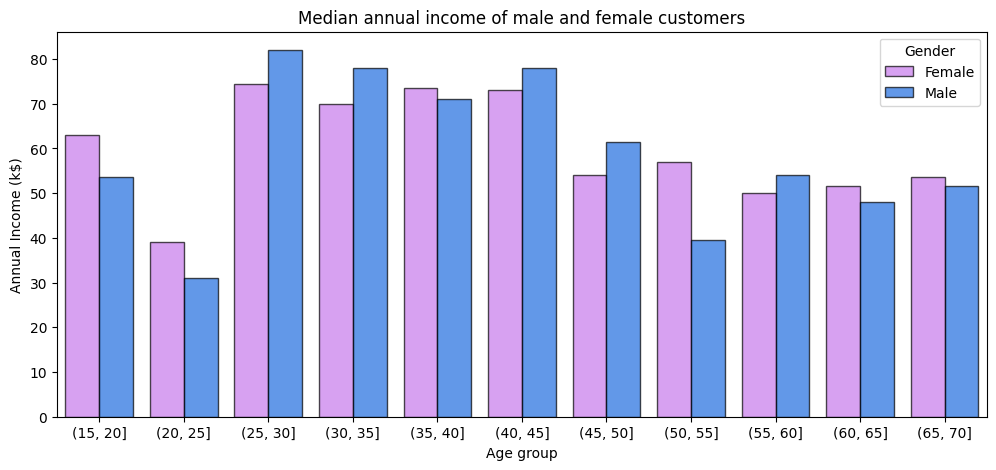

In [14]:
fig,ax=plt.subplots(figsize=(12, 5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group, palette=['#cc66ff', '#0066ff'], alpha=0.7, edgecolor='k', ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

수입이 높은 사람들은 25-45세 사이이다. 25-30세 그룹과 50-55세 그룹이 성별 간 수입 차이가 크다.

##3.2 Correlations
숫자형 변수들 간의 상관관계를 보자.

In [25]:
from scipy.stats import pearsonr

#calculating Pearson's correlation
corr, _ =pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

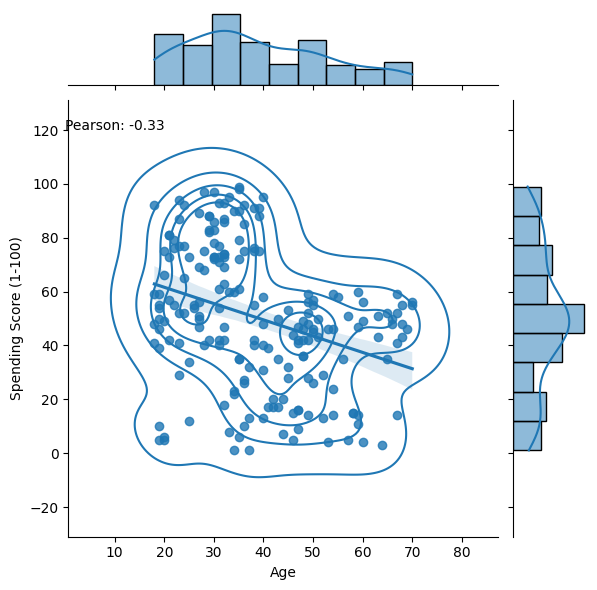

In [30]:
sns.jointplot(data=mall_data, x='Age', y='Spending Score (1-100)', kind='reg').plot_joint(sns.kdeplot, zorder=0, n_levels=6)
plt.text(0, 120, 'Pearson: {:.2f}'.format(corr))
plt.show()

In [31]:
#calculating Pearson's correlations
corr1, _ =pearsonr(males_age.values, males_income.values)
corr2, _ =pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender', aspect=1.5)
plt.text(15, 87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65, 80, 'Pearson: {:.2f}'.format(corr2), color='orange')
plt.show()

TypeError: ignored

두 성별 모두에서 **나이와 수입**의 상관관계는 거의 없다.

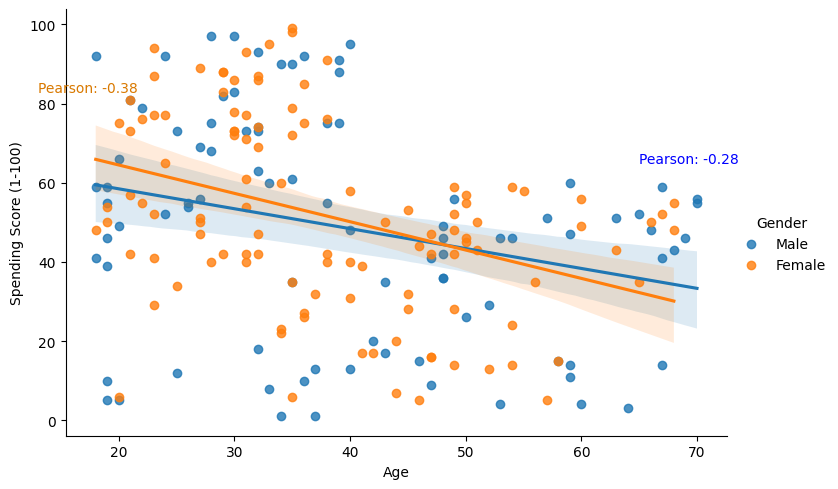

In [33]:
#calculating Pearson's correlations
corr1, _ =pearsonr(males_age.values, males_spending.values)
corr2, _ =pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender', aspect=1.5)
plt.text(65, 65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13, 83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')
plt.show()

두 성별 모두에서 **나이와 소비 점수**는 약한 음의 상관관계가 있다.


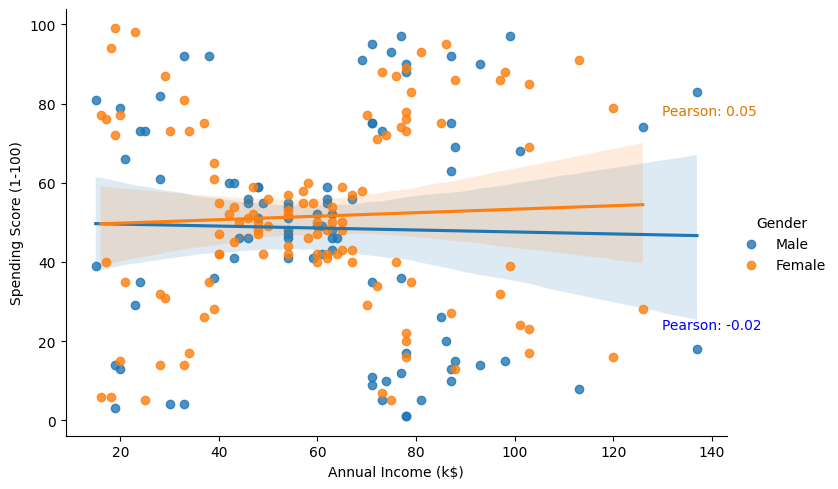

In [34]:
#calculating Pearson's correlations
corr1, _ =pearsonr(males_income.values, males_spending.values)
corr2, _ =pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender', aspect=1.5)
plt.text(130, 23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130, 77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')
plt.show()

**수입과 소비 점수** 사이 상관관계도 거의 없다.

#4. Clustering

##4.1 K-Means

###4.1.1 Description
가장 잘 알려진 군집 알고리즘. 실행이 쉽고 간단하다.
1. 샘플을 시드 포인트를 이용해 여러 그룹으로 나눈다.
2. 센트로이드간의 거리를 계산해서 가까운 샘플들을 클러스터에 할당.
3. 업데이트된 센트로이드를 계산한다.

알고리즘이 수렴할 때까지 이 과정을 반복한다.

K-Means의 목적은 이너셔를 최소화 하는 것. 지역 최소점으로 수렴할 문제가 있지만 나쁘지 않다.

K-Means의 세가지 메인 파라미터
1. Initalisation criteria :k-means++, 서로 거리가 먼 센트로이드를 설정한다.
2. Number of clusters : 엘보 또는 실루엣 점수 이용. 다른 방법들도 있으나 사이킷런에 설치되지 않음.
3. A distance metric : 사이킷런에서는 추천하지 않음. 사이킷런이 거리 계산에 사용하느 유클리드 방법의 단점을 보완한 것.

K-Means의 핵심
- 유클리드 거리 계산법 사용
- 클러스터 개수를 지정해야함
- 클러스터 멤버간의 평균 거리로 센트로이드가 계산됨
- 클러스터들은 등방성+볼록함
- Stochastic 알고리즘 : 결과가 초기값에 의존함
- 등분산성
- curse of dimensionality
- 병렬 실행 가능

###4.1.2 Use case - customers segmentation

In [35]:
from sklearn.cluster import KMeans 

클러스터링에는 숫자형 변수만 사용된다. 따라서 성별은 사용하지 않음.

In [36]:
X_numerics=mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] #subset with numeric variables only

**엘보 방법**

이너셔는 2~10. 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

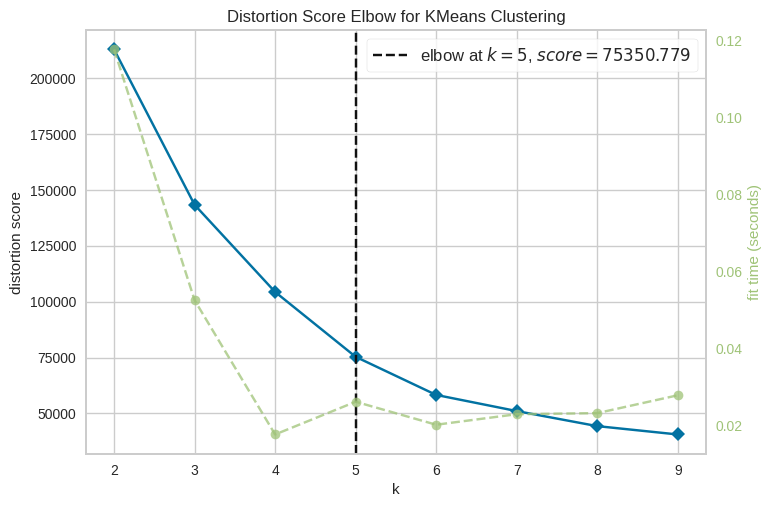

In [37]:
from yellowbrick.cluster import KElbowVisualizer

model=KMeans(random_state=1)
visualizer=KElbowVisualizer(model, k=(2, 10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

클러스터 개수가 증가할수록 distortion 점수는 올라가지만 명확한 엘보가 보이지는 않음. 알고리즘이 5를 추천함.

**실루엣 점수**

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

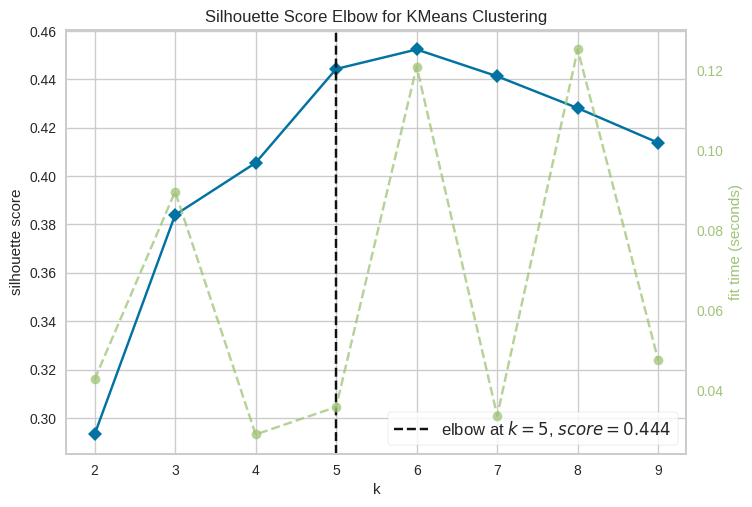

In [38]:
model=KMeans(random_state=1)
visualizer=KElbowVisualizer(model, k=(2, 10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

실루엣도 5나 6이 좋아보임.

두가지를 비교해보자.

- 5개 클러스터

In [39]:
KM_5_clusters=KMeans(n_clusters=5, init='k-means++').fit(X_numerics) #initialise and fit K-Means model
KM5_clustered=X_numerics.copy()
KM5_clustered.loc[:, 'Cluster']=KM_5_clusters.labels_ #append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


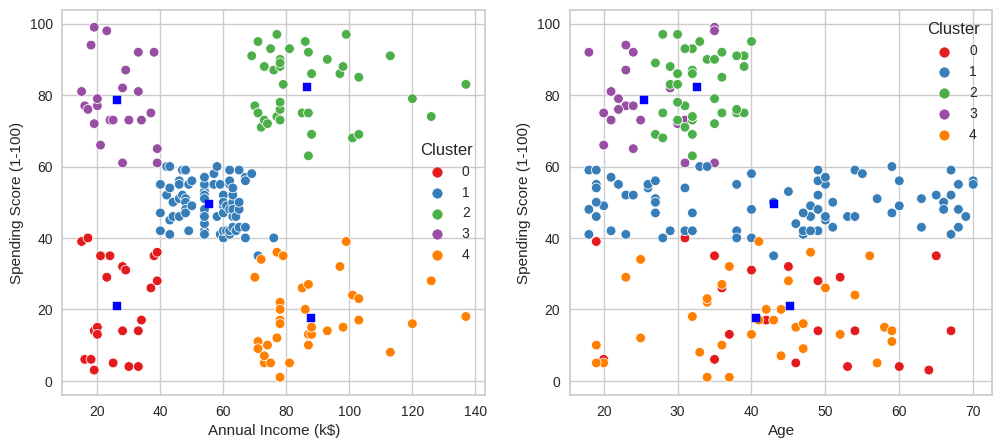

In [42]:
fig1, (axes)=plt.subplots(1, 2, figsize=(12, 5))
scat_1=sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered, hue='Cluster', ax=axes[0], palette='Set1', legend='full')
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered, hue='Cluster', palette='Set1', ax=axes[1], legend='full')
axes[0].scatter(KM_5_clusters.cluster_centers_[:, 1], KM_5_clusters.cluster_centers_[:, 2], marker='s', s=40, c='blue')
axes[1].scatter(KM_5_clusters.cluster_centers_[:, 0], KM_5_clusters.cluster_centers_[:, 2], marker='s', s=40, c='blue')
plt.show()

- 수입 낮+소비점수 높
- 수입 중간+소비점수 중간
- 수입 높+소비점수 낮
- 수입 높+소비점수 높
- 수입 낮+소비점수 낮

5가지 그룹. 나이에 따라서는 뚜렷한 그룹이 안보인다.

In [43]:
#각 클러스터의 크기
KM_clust_sizes=KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns=['KM_size']
KM_clust_sizes

,KM_size
Cluster,
0,23
1,79
2,39
3,23
4,36


가장 큰 그룹은 79개의 관측치. 가장 작은 그룹은 23개의 관측치. 

In [48]:
#3D 시각화 코드

from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(7, 7))
ax=Axes3D(fig, rect=[0, 0, 0.99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'], s=35, edgecolor='k', cmap=plt.cm.Set1)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist=12
plt.show()

<ipython-input-48-d0b1816b05a0>:11: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
<ipython-input-48-d0b1816b05a0>:12: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
<ipython-input-48-d0b1816b05a0>:13: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])
<ipython-input-48-d0b1816b05a0>:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=12


<Figure size 700x700 with 0 Axes>

?

In [49]:
#plotly ver.

import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x=db[db['Cluster']==n]['Age'],
        y=db[db['Cluster']==n]['Spending Score (1-100)'],
        z=db[db['Cluster']==n]['Annual Income (k$)'],
        mode='markers',
        name=name,
        marker=dict(
            size=5
        )
     )
trace0=tracer(KM5_clustered, 0, 'Cluster 0')
trace1=tracer(KM5_clustered, 1, 'Cluster 1')
trace2=tracer(KM5_clustered, 2, 'Cluster 2')
trace3=tracer(KM5_clustered, 3, 'Cluster 3')
trace4=tracer(KM5_clustered, 4, 'Cluster 4')

data=[trace0, trace1, trace2, trace3, trace4]

layout=go.Layout(
    title='Clusters by K-Means',
    scene=dict(
            xaxis=dict(title='Age'),
            yaxis=dict(title='Spending Score'),
            zaxis=dict(title='Annual Income')
        )
)

fig=go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

각 클러스터의 퀄리티를 보기 위한 실루엣 플롯을 그려보자.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



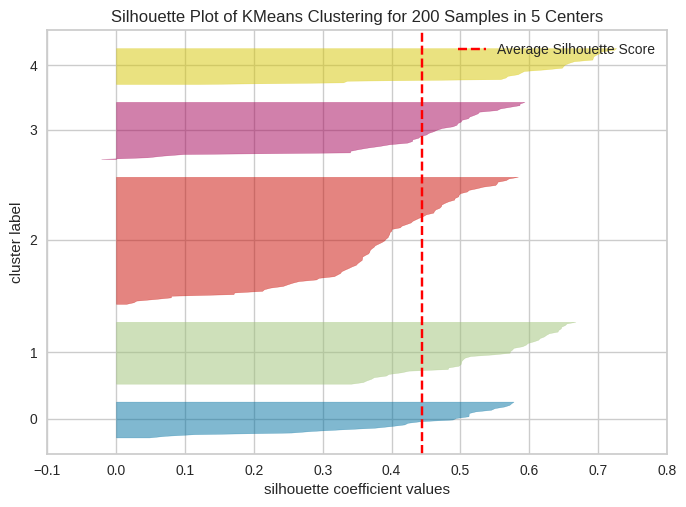

In [50]:
from yellowbrick.cluster import SilhouetteVisualizer
model=KMeans(n_clusters=5, random_state=0)
visualizer=SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 6개 클러스터

In [53]:
KM_6_clusters=KMeans(n_clusters=6, init='k-means++').fit(X_numerics) #initialise and fit K-Means model
KM6_clustered=X_numerics.copy()
KM6_clustered.loc[:, 'Cluster']=KM_6_clusters.labels_ #append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



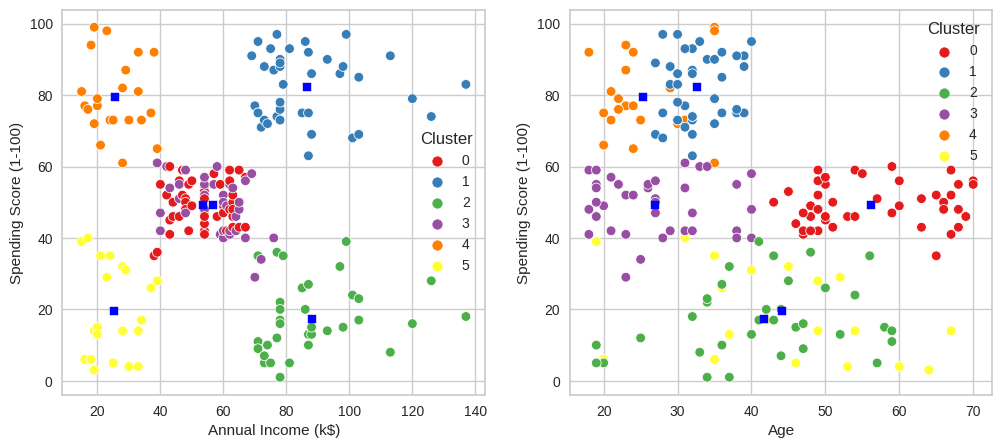

In [54]:
fig11, (axes)=plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered, hue='Cluster', ax=axes[0], palette='Set1', legend='full')
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered, hue='Cluster', palette='Set1', ax=axes[1], legend='full')

#plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:, 1], KM_6_clusters.cluster_centers_[:, 2], marker='s', s=40, c='blue')
axes[1].scatter(KM_6_clusters.cluster_centers_[:, 0], KM_6_clusters.cluster_centers_[:, 2], marker='s', s=40, c='blue')
plt.show()

- 수입 중간+소비점수 중간+젊은 손님
- 수입 높+소비점수 낮
- 수입 중간+소비점수 중간+나이 든 손님
- 수입 높+소비점수 높
- 수입 낮+소비점수 낮
- 수입 낮+소비점수 높

6가지 그룹이 나옴.

In [55]:
#사이즈 확인
KM6_clust_sizes=KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns=['KM_size']
KM6_clust_sizes

,KM_size
Cluster,
0,45
1,39
2,35
3,38
4,22
5,21


In [56]:
#Plotly interactive 3D plot
trace0=tracer(KM6_clustered, 0, 'Cluster 0')
trace1=tracer(KM6_clustered, 1, 'Cluster 1')
trace2=tracer(KM6_clustered, 2, 'Cluster 2')
trace3=tracer(KM6_clustered, 3, 'Cluster 3')
trace4=tracer(KM6_clustered, 4, 'Cluster 4')
trace5=tracer(KM6_clustered, 5, 'Cluster 5')
data=[trace0, trace1, trace2, trace3, trace4, trace5]
layout=go.Layout(
    title='Clusters by K-Means',
    scene=dict(
          xaxis=dict(title='Age'),
          yaxis=dict(title='Spending Score'),
          zaxis=dict(title='Annual Income')
        )
)

fig=go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



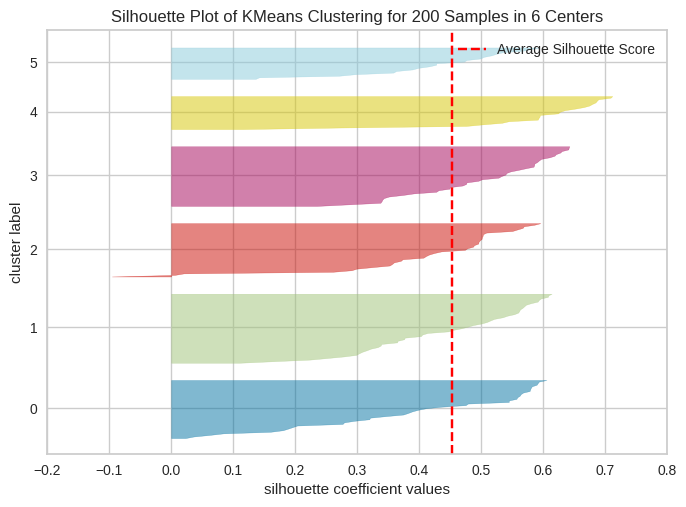

In [57]:
#실루엣 그래프
model=KMeans(n_clusters=6, random_state=0)
visualizer=SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

##4.2 DBSCAN
Density-Based Spatial Clustering of Applications with Noise

###4.2.1 Description
dense regions 기반 아이디어. natural 클러스터들은 밀집도에 따라 구성될 것이다.

파라미터
- Eps : distance
- MinPts : 엡실론 안에 있는 최소 포인트 개수

dense region은 엡실론 안에 있는 최소 포인트 개수에 따라 결정된다. border points.

장점
- 클러스터 개수를 알아서 찾아준다.
- K-Means에 비하면 조금 더 다양한 형태의 클러스터들을 구분 가능
- 이상치를 탐지함

단점
- 계산 비용이 높음.
- 다양한 분포를 가진 클러스터 구분을 못함

###4.2.2 Use case - customers segmentation

In [58]:
from sklearn.cluster import DBSCAN

두가지 파라미터 (eps, min_samples). 뭐가 제일 나은지 모르니까 확인해보자.

In [59]:
from itertools import product

eps_values=np.arange(8, 12.75, 0.25) #eps values to be investigated
min_samples=np.arange(3, 10) #min_samples values to be investigated
DBSCAN_params=list(product(eps_values, min_samples))

자동으로 생성된 클러스터 개수를 확인해보자.

In [60]:
from sklearn.metrics import silhouette_score

no_of_clusters=[]
sil_score=[]

for p in DBSCAN_params:
  DBS_clustering=DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
  no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
  sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

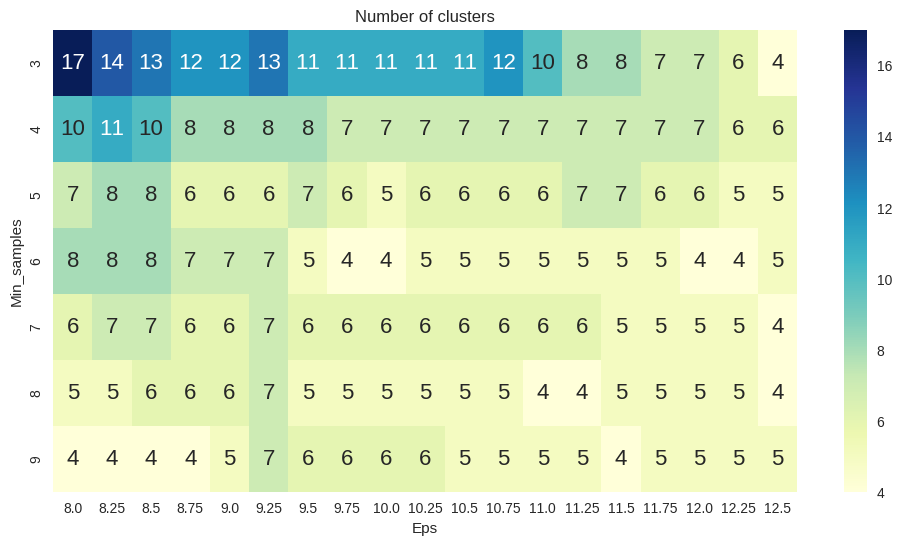

In [61]:
#각 파라미터 조합별로 클러스터 개수의 히트맵
tmp=pd.DataFrame.from_records(DBSCAN_params, columns=['Eps', 'Min_samples'])   
tmp['No_of_clusters']=no_of_clusters

pivot_1=pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')
fig, ax=plt.subplots(figsize=(12, 6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size' : 16}, cmap='YlGnBu', ax=ax)
ax.set_title('Number of clusters')
plt.show()

너무 다양하다. 하지만 4~7이 대부분. 실루엣 점수로 다시 히트맵 그려서 조합 결정하자.

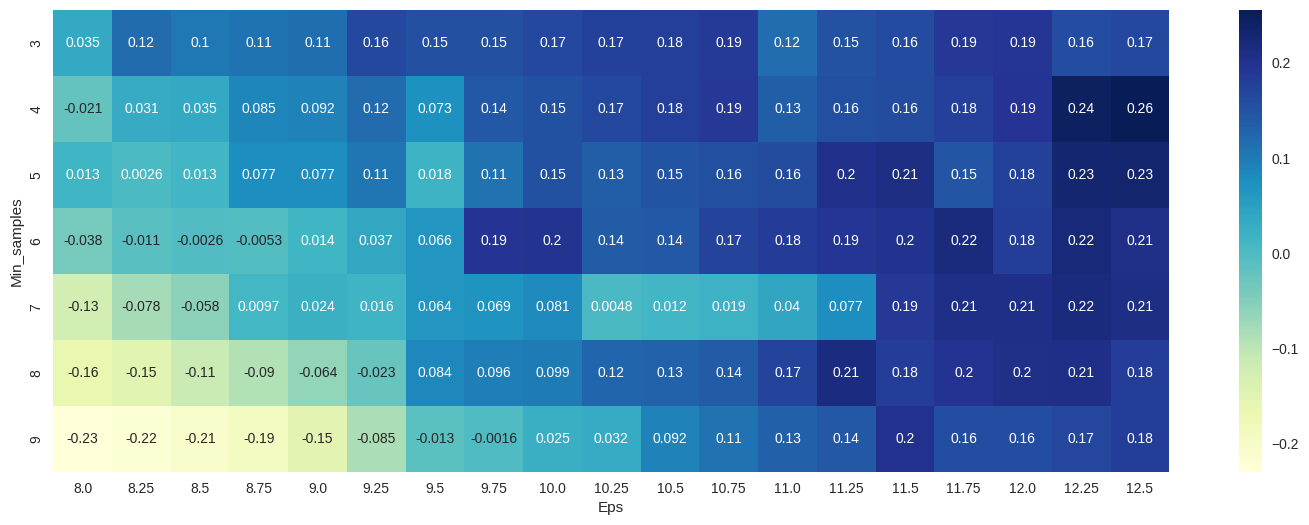

In [62]:
tmp=pd.DataFrame.from_records(DBSCAN_params, columns=['Eps', 'Min_samples'])   
tmp['Sil_score']=sil_score

pivot_1=pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')
fig, ax=plt.subplots(figsize=(18, 6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size' : 10}, cmap='YlGnBu', ax=ax)
plt.show()

eps=12.5, min_samples=4 로 결정.

In [63]:
DBS_clustering=DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)
DBSCAN_clustered=X_numerics.copy()
DBSCAN_clustered.loc[:, 'Cluster']=DBS_clustering.labels_ #append labels to points

In [64]:
#클러스터 사이즈 확인
DBSCAN_clust_sizes=DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns=['DBSCAN_size']
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


여기서 -1인 이상치! 클러스터 크기는 다양함.

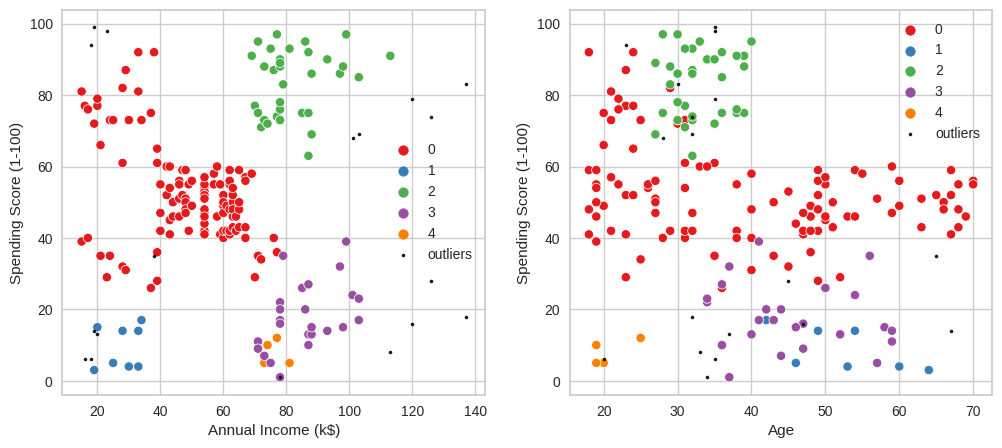

In [65]:
outliers=DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes)=plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1], hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1], hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c='k')
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c='k')
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')
plt.show()

이상치가 있다고 탐지함. eps나 min_samples에 따라 클러스터에 포함되지 못한 점들.

##4.3 Affinity Propagation

###4.3.1 Description
두 점 사이가 수렴할 때까지 메세지 보내기. 메세지는 이 두 점이 얼마나 비슷한지를 측정하는 방법. 클러스터 개수를 자동으로 찾아준다. 복잡 비용이 높긴 함. 그러나 초기값에 대한 민감도가 낮다는 장점이 있다.

파라미터
- preference : 음수, 얼마나 많은 exemplar가 사용될 지 결정
- Damping factor : 수치적 변동을 방지

###4.3.2 Use case - customers segmentation

In [66]:
from sklearn.cluster import AffinityPropagation

In [67]:
no_of_clusters=[]
preferences=range(-20000, -5000, 100) #arbitraty chosen range
af_sil_score=[] #silouette scores

for p in preferences:
  AF=AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
  no_of_clusters.append((len(np.unique(AF.labels_))))
  af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results=pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() #display only 5 best scores

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


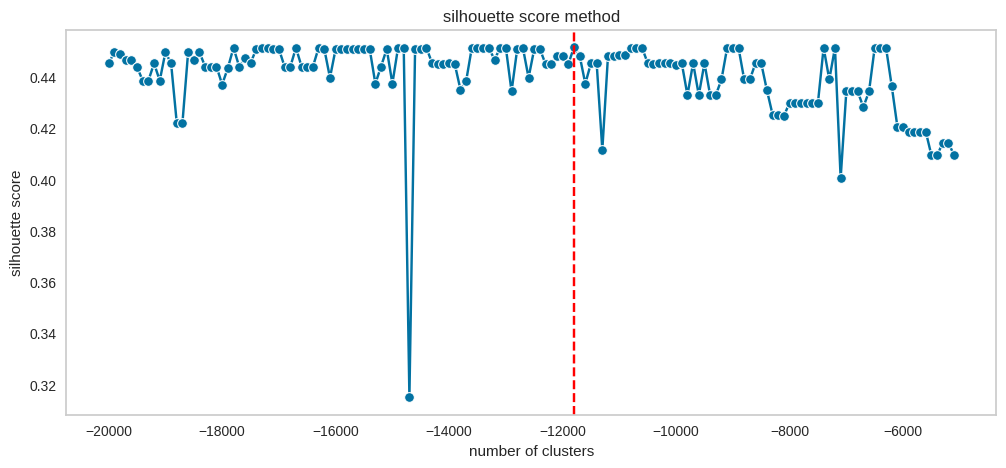

In [69]:
#시각화
fig, ax=plt.subplots(figsize=(12, 5))
ax=sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title('silhouette score method')
ax.set_xlabel('number of clusters')
ax.set_ylabel('silhouette score')
ax.axvline(-11800, ls='--', c='red')
plt.grid()
plt.show()

In [70]:
AF=AffinityPropagation(preference=-11800).fit(X_numerics)

In [71]:
AF_clustered=X_numerics.copy()
AF_clustered.loc[:, 'Cluster']=AF.labels_ #append labels to points

In [72]:
AF_clust_sizes=AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns=['AF_size']
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


이전보다 조금 더 고른 클러스터들.

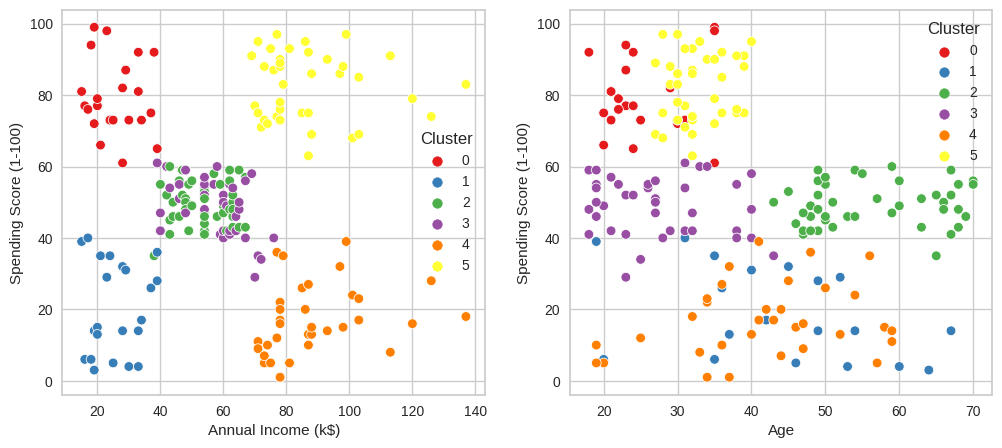

In [73]:
fig3, (ax_af)=plt.subplots(1, 2, figsize=(12, 5))
scat_1=sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered, hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered, hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')
plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

K-Means에 비해 좀 더 고른 클러스터들이 생성되었다.

#5. Comparison and discussion
3가지 알고리즘을 비교해보자.

- K-Means

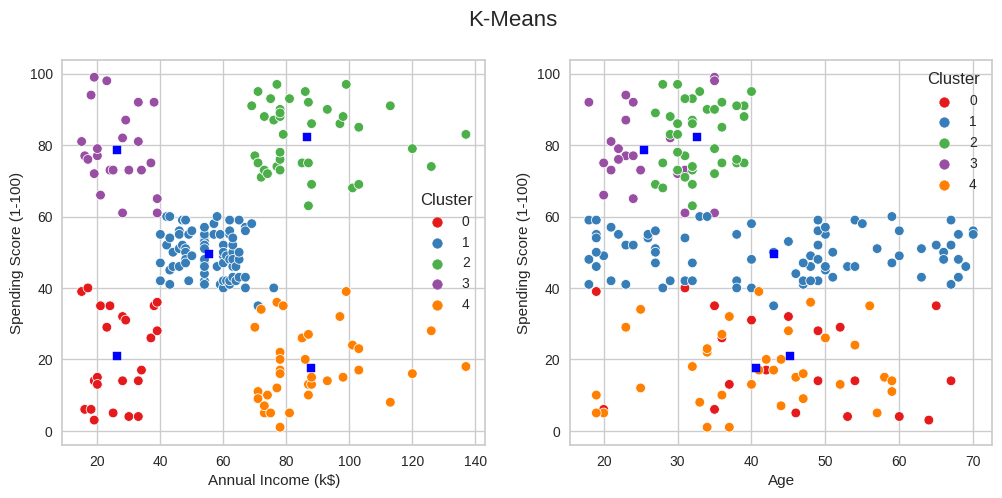

In [74]:
#클러스터 5개인 K-Means
fig1.suptitle('K-Means', fontsize=16)
fig1

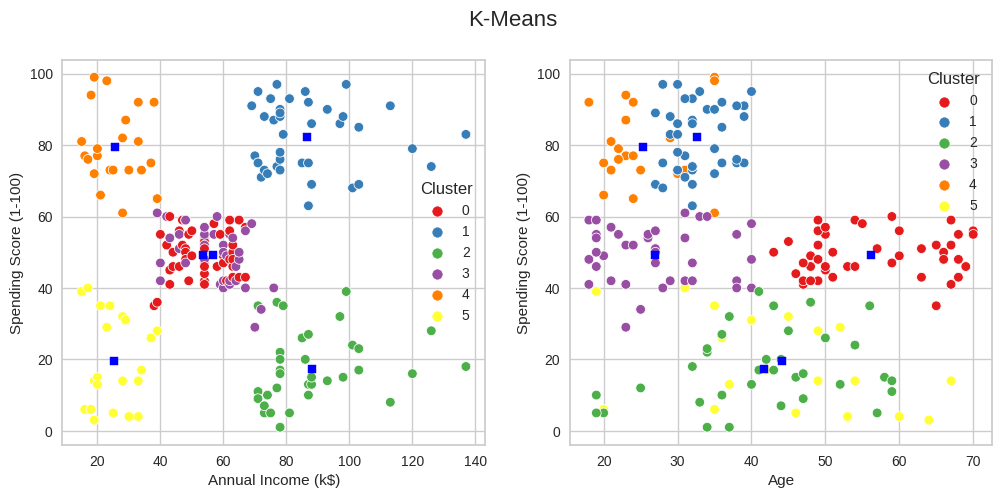

In [75]:
#클러스터 6개인 K-Means
fig11.suptitle('K-Means', fontsize=16)
fig11

- DBSCAN

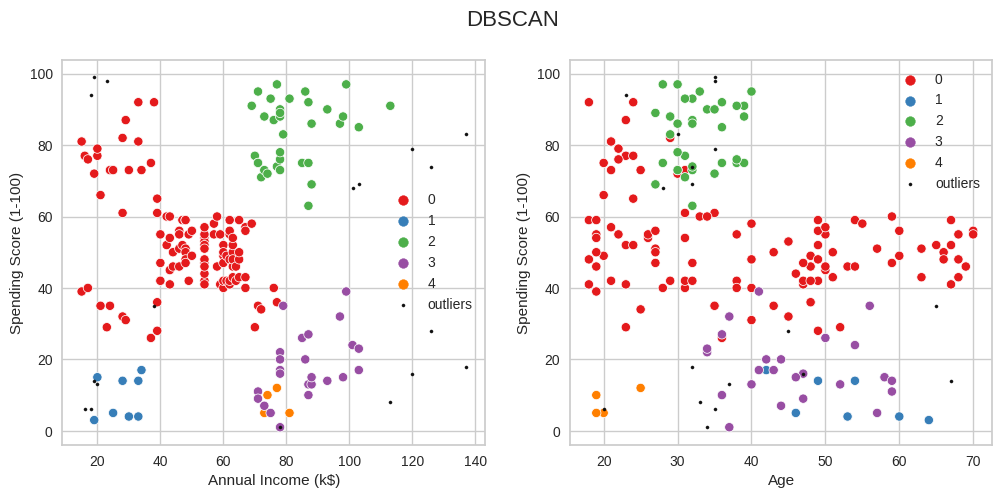

In [76]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

- Affinity Propagation

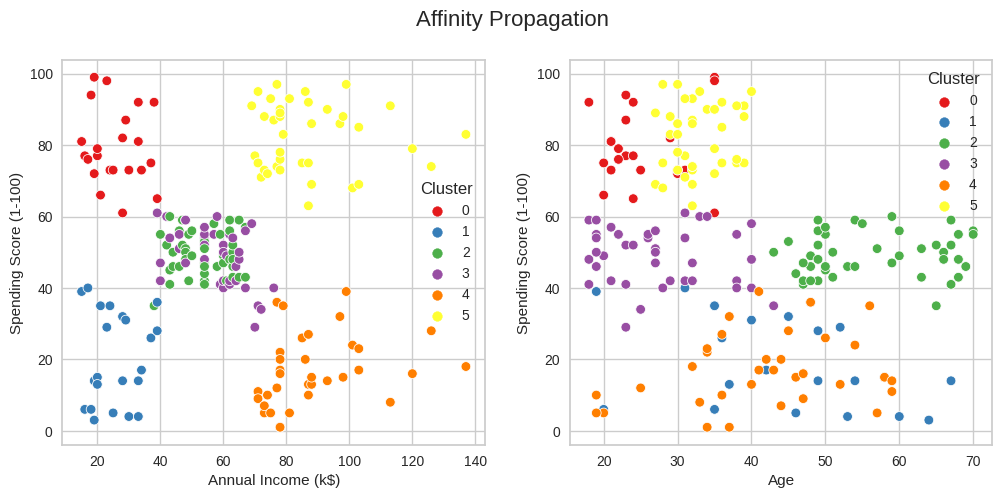

In [77]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

우선 DBSCAN은 탈락. 아마 DBSCAN은 밀집도에 따라 클러스터를 생성하기 때문일 것. 어떤 클러스터가 밀집도가 좀 떨어지면 클러스터로 인식 안함.

따라서 K-Means나 AP의 6개 클러스터가 적합해보인다.